# Simulation of electron-nuclear spin dynamics

This notebook allows to simulate the dynamics of a $Er^{3+}$ electron spin ($S = 1/2$) with a $^{183}W$ ($I = 1/2$) down to the pulse level using QuTip (https://qutip.org/docs/latest/).

The exact shape of the pulse used in the simulation is determined upon the experimental relaxation rate of the MW cavity, and can be freely modified by the user to simulate any case scenario.

In [1]:
from multiprocessing import Pool, cpu_count
from src.utility import *
from src.pulses import *
from src.plotting import*

%matplotlib widget
worker_count = max(cpu_count() - 1, 1)

## Introduction

The system considered is a tensor space of the electron spin S=1/2 and the nuclear spin I=1/2 subspaces.

The coupling of the intrinsic magnetic moment of the electron spin and the nuclear spin is called the hyperfine interaction. Since the magnetic moment of the electron spin is much larger than that of the nuclear spin, the electron strongly influences the dynamics of the surrounding nuclear spins. As a consequence, electrons can be used to manipulate them (see the figure below).

Here, flipping the electron spin (by applying a $\pi$ pulse) changes the quantization axis $\mathbf{m_{\uparrow \downarrow}}$ of the surrounding $^{183}W$ nuclear spins. By choosing the right period $2 \tau$ between the $\pi$ pulses, one can selectively address a single nuclear spin and flip its state. It is upon this technique that all dynamical decoupling sequences stem from.

<img src="figs/Quantization_axis_LB_CaWO4.jpg" width="600"/>

The static spin Hamiltonian comprises the electron and nuclear Zeeman interactions ($H_{EZ}$ and $H_{NZ}$ respectively) as well as the hyperfine interaction:

$$H_0 = H_{EZ} + H_{NZ} + H_{DD}$$

In the following, we choose to express the Hamiltonian exclusively in terms of angular frequencies (i.e. $H / \hbar$ which we will write simply as $H$). Using the secular approximation, the static Hamiltonian of the system in the rotating frame may be written as:

$$H_0 = \vec{\omega_S} \cdot \vec{S} + \vec{\omega_I} \cdot \vec{I} + AS_ZI_z + BS_zI_x + BS_zI_y$$

where $A$ and $B$ are the secular hyperfine coupling constants.

By applying the rotating wave approximation, we can neglect the electron Zeeman interaction so that the static Hamiltonian becomes:

$$H_0 = \vec{\omega_I} \cdot \vec{I} + AS_ZI_z + BS_zI_x + BS_zI_y$$

The total Hamiltonian $H$ comprises the static Hamiltonian $H_0$ as well as the time-dependent Hamiltonian $H_t$ which is simply:

$$H_t = f(t) \sigma_z$$

where $f: t \rightarrow f(t)$ is the pulse function to apply to the electron (which depends on the sequence considered).

#### References
* [Léo Balembois. Magnetic resonance of a single electron spin and its magnetic environment by photon counting. Université Paris-Saclay, 2023.](https://theses.hal.science/tel-04165482)
* [Arthur Schweiger and Gunnar Jeschke. Principles of pulse electron paramagnetic resonance. Oxford University Press, 2001.](https://global.oup.com/academic/product/principles-of-pulse-electron-paramagnetic-resonance-9780198506348?cc=fr&lang=en&)
* [T. H. Taminiau et al. Detection and Control of Individual Nuclear Spins Using a Weakly Coupled Electron Spin. Physical Review Letters 109.137602, 2012.](https://link.aps.org/doi/10.1103/PhysRevLett.109.137602)

### Parameters
Frequencies are given in MHz and durations in $\mu s$. Therefore, the time basis will be in $\mu s$.

In [2]:
# Cavity parameters
kappa_c = 2*np.pi*0.400 # rad/us (400 kHz)
kappa = kappa_c

# Spin parameters
h    = 6.6260693e-34       # J.s
mu_N = 5.0507836991e-27    # Nuclear magneton in J/T
g_N  = 0.2355695           # g nuclear 183W (INDC International Nuclear Data Committee)
mu_I = mu_N*g_N            # Nuclear magneton * g nuclear 183W  in J/T

# Magnetic field
B0 = 0.47 # T
theta = 0*np.pi/180 # rad
phi = 0*np.pi/180 # rad
B_field = np.array([B0*np.sin(theta)*np.cos(phi), B0*np.sin(theta)*np.sin(phi), B0*np.cos(theta)])

omega_L = 2*np.pi*mu_I/h*1e-6*B0 # rad/us

# Hyperfine constants
#832_at_(68.4,0.0,187.9)_W
#A_sim, B_sim = np.genfromtxt('hyperfine_parameters\832_at_(%.1f,%.1f,%.1f)_W.csv'%(B_field[0]*1e3, B_field[1]*1e3, B_field[2]*1e3), delimiter=',')[1:, -2:].T*1e-3 # MHz
A_sim, B_sim = np.genfromtxt('hyperfine_parameters/832_at_(68.4,0.0,187.9)_W.csv', delimiter=',')[1:, -2:].T*1e-3 # MHz
A_list = 2*np.pi*np.array(A_sim[:30]) # rad/us (MHz)
B_list = 2*np.pi*np.array(B_sim[:30]) # rad/us (MHz)

A = A_list[20]
B = B_list[20]

# Pulse parameters
pi_pulse_duration = 700e-3 # us (700 ns)

# Rabi angle of the input MW pulse so that the filtered pulse applies a pi Rabi angle
input_rabi_angle = np.pi * kappa/(2*np.sqrt(kappa_c))
# Corresponding input Rabi frequency
rabi_freq = input_rabi_angle/pi_pulse_duration # MHz

### Setup of the operators and the static Hamiltonian

In [3]:
S = 1/2
nS = int(2*S+1)
(Sx,Sy,Sz) = generate_S(S)

In [4]:
I = 1/2
nI = int(2*I+1)
(Ix,Iy,Iz) = generate_S(I)

In [5]:
# Nuclear Zeeman interaction
omega_Ix = 2*np.pi*mu_I/h*1e-6*B_field[0]
omega_Iy = 2*np.pi*mu_I/h*1e-6*B_field[1]
omega_Iz = 2*np.pi*mu_I/h*1e-6*B_field[2]
H_NZ = tensor(qeye(nS), omega_Ix*Ix + omega_Iy*Iy + omega_Iz*Iz)

# Electron-nuclear dipole-dipole interaction (hyperfine)
H_DD = A*tensor(Sz,Iz) + B*tensor(Sz,Ix) + B*tensor(Sz,Iy)

# Total static Hamiltonian
H0 = H_NZ + H_DD

In [6]:
H0

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 2.66480335+0.j          0.04195886-0.04195886j  0.        +0.j
   0.        +0.j        ]
 [ 0.04195886+0.04195886j -2.66480335+0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          2.63792748+0.j
  -0.04195886+0.04195886j]
 [ 0.        +0.j          0.        +0.j         -0.04195886-0.04195886j
  -2.63792748+0.j        ]]

In [7]:
H0.eigenstates()[0]/(2*np.pi) # Eigenenergies in MHz

array([-0.42422176, -0.4199454 ,  0.4199454 ,  0.42422176])

In [8]:
H0.eigenstates()[1]

array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[-0.00787132+0.00787132j]
        [ 0.99993804+0.j        ]
        [ 0.        +0.j        ]
        [ 0.        +0.j        ]]                                        ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.        +0.j        ]
        [0.        +0.j        ]
        [0.00795149-0.00795149j]
        [0.99993677+0.j        ]]                                         ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[ 0.        +0.j        ]
        [ 0.        +0.j        ]
        [ 0.99993677+0.j        ]
        [-0.00795149-0.00795149j]]                                        ,
       Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
       Qobj data =
       [[0.99993804+0.j        ]
        [0.00787132+0.00787132j]
        [0.        +0.j    

# Pi pulse definition

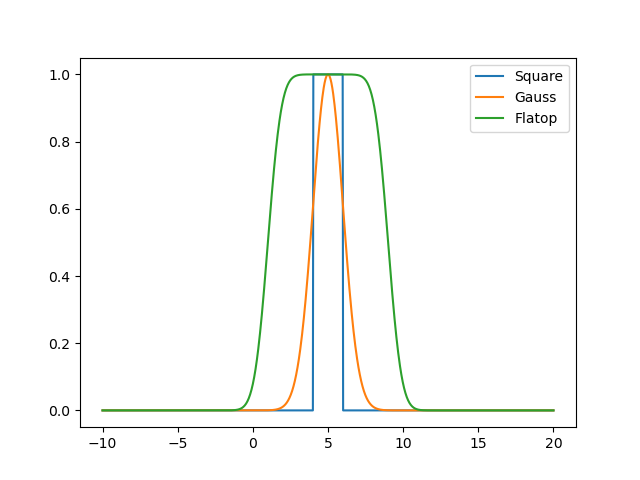

In [9]:
from scipy.special import erf

def ErfRising(t, sigma, amplitude, t0):
    return amplitude * (erf((t - t0) / sigma) + 1) / 2

def square_pulse(t, args):
    pulse_duration = args['pulse_duration']
    rabi_freq = args['rabi_freq']
    t0 = args['t0']
    if t > (t0 - pulse_duration/2) and t < (t0 + pulse_duration/2):
        return rabi_freq
    else:
        return 0

def gaussian_pulse(t, args):
    sigma = args['sigma']
    rabi_freq = args['rabi_freq']
    t0 = args['t0']
    if t > (t0-6*sigma) and t < (t0+6*sigma):
        return rabi_freq * np.exp(-((t - t0) ** 2) / (2 * sigma ** 2))
    else: 
        return 0

def flattop_pulse(t, args):
    pulse_duration = args['pulse_duration']
    sigma = args['sigma']
    rabi_freq = args['rabi_freq']
    t0 = args['t0']
    if t > (t0 - pulse_duration/2 - 6*sigma) and t < (t0 - pulse_duration/2):
        return ErfRising(t, sigma, rabi_freq, t0 - pulse_duration/2 - 3*sigma)
        
    elif t > (t0 - pulse_duration/2) and t < (t0 + pulse_duration/2):
        return rabi_freq
        
    elif t > (t0 + pulse_duration/2) and t < (t0 + pulse_duration/2 + 6*sigma):
        return rabi_freq-ErfRising(t, sigma, rabi_freq, t0 + pulse_duration/2 + 3*sigma)
        
    else:
        return 0

args = {
    'sigma': 1,
    'pulse_duration': 2,
    'rabi_freq': 1,
    't0': 5
}

t = np.linspace(-10, 20, 1000)
p = [square_pulse(_t, args) for _t in t]
g = [gaussian_pulse(_t, args) for _t in t]
ft = [flattop_pulse(_t, args) for _t in t]
    
plt.figure()
plt.plot(t, p, label="Square")
plt.plot(t, g, label="Gauss")
plt.plot(t, ft, label="Flatop")
plt.legend()

In [11]:
# Applying a pi/2 pulse on the e- spin at the beginning and end of the sequence
H_square = [tensor(sigmay(),qeye(nI)), square_pulse]
H_gaussian = [tensor(sigmay(),qeye(nI)), gaussian_pulse]
H_flattop = [tensor(sigmay(),qeye(nI)), flattop_pulse]

ket0 = H0.eigenstates()[1][0] # When the last 2 components of the state vector are nil, the electron spin is in the ground state

# Simulation
rabi_freqs = np.linspace(0, 2, 100)

sz_square = []
sz_gaussian = []
sz_falttop = []
for f in rabi_freqs:
    args = {
        'sigma': 1,
        'pulse_duration': 2,
        'rabi_freq': f,
        't0': 10
    }
    t = np.linspace(0, 20, 100)
    result = mesolve([H0, H_square], ket0, t, [], [], args=args)
    sz_square.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    
    result = mesolve([H0, H_gaussian], ket0, t, [], [], args=args)
    sz_gaussian.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    
    result = mesolve([H0, H_flattop], ket0, t, [], [], args=args)
    sz_falttop.append(expect(tensor(Sz, qeye(nI)), result.states)[-1])
    

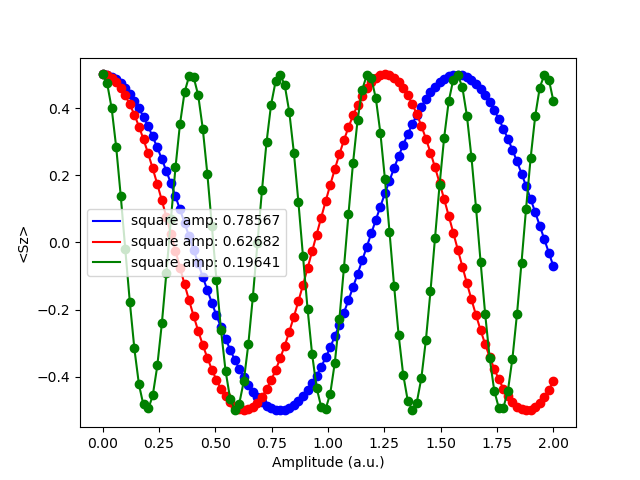

In [12]:
def rabi_fit(t,f,a,b):
    return a*(b - np.cos(2*np.pi*f*t))

plt.figure()
guess = [0.7, -0.5, 0]
popt, pcov = curve_fit(rabi_fit, rabi_freqs, sz_square, guess)
plt.plot(rabi_freqs, sz_square, 'ob')
plt.plot(rabi_freqs, rabi_fit(rabi_freqs, *popt), 'b', label="square amp: %.5f"%(1/popt[0]/2))

guess = [0.6, -0.5, 0]
popt, pcov = curve_fit(rabi_fit, rabi_freqs, sz_gaussian, guess)
plt.plot(rabi_freqs, sz_gaussian, 'or')
plt.plot(rabi_freqs, rabi_fit(rabi_freqs, *popt), 'r', label="square amp: %.5f"%(1/popt[0]/2))

guess = [3, -0.5, 0]
popt, pcov = curve_fit(rabi_fit, rabi_freqs, sz_falttop, guess)
plt.plot(rabi_freqs, sz_falttop, 'og')
plt.plot(rabi_freqs, rabi_fit(rabi_freqs, *popt), 'g', label="square amp: %.5f"%(1/popt[0]/2))

plt.xlabel("Amplitude (a.u.)")
plt.ylabel("<Sz>")
plt.legend()